<h3>Image classifier</h3>

Training an image classifier

We will do the following steps in order:
<ol>
<li>Load and normalize the CIFAR10 training and test datasets using torchvision</li>

<li>Define a Convolutional Neural Network</li>

<li>Define a loss function</li>

<li>Train the network on the training data</li>

<li>Test the network on the test data</li>
</ol>


Load and normalize dataset using torchvision

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].



In [15]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root="./data", train=True,
                                        download=True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers = 2)
testset = torchvision.datasets.CIFAR10(root="./data", train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


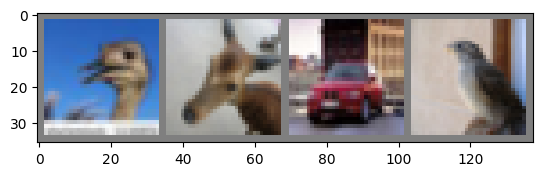

bird  deer  car   bird 


In [16]:
import matplotlib.pyplot as plt
import numpy as np


#function to show the image
def imshow(img):#labels
  img = img / 2 + 0.5 #scales the pixes back to range [0, 1]
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  #for i in range(len(labels)):
     # plt.text(i * (npimg.shape[2] // len(labels)), -10,
                 #classes[labels[i]], ha='center', va='bottom', fontsize=12)
      #plt.axis('off') # Hide axis
  plt.show()
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images)) #labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [17]:
# Defining the Convulational Neural Network
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return x
net = Net()

In [18]:
# Defining a loss function
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)

In [19]:
#Training the network
for epoch in range(2):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    #get the inputs
    inputs, labels = data

    #clear the gradients
    optimizer.zero_grad()
    #forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    #print statistics
    running_loss += loss.item()
    if i % 2000 == 1999:
       #print every 2000 minibatches
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        running_loss = 0.0
print("Finished Training")

[1,  2000] loss: 2.236
[1,  4000] loss: 2.004
[1,  6000] loss: 1.937
[1,  8000] loss: 1.953
[1, 10000] loss: 1.938
[1, 12000] loss: 1.972
[2,  2000] loss: 1.941
[2,  4000] loss: 1.918
[2,  6000] loss: 1.955
[2,  8000] loss: 2.009
[2, 10000] loss: 1.904
[2, 12000] loss: 1.911
Finished Training


In [20]:
#save the model
PATH = "./image_model.pth"
torch.save(net.state_dict(), PATH)

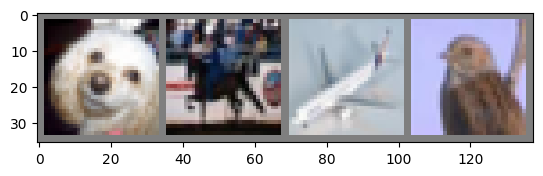

GroundTruth:  dog   horse plane bird 


In [21]:
#Testing the network on test data
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [22]:
#load back saved model
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [23]:
outputs = net(images)

In [24]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))


Predicted:  horse car   plane cat  


In [25]:
#check results for whole dataset
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 28 %


In [26]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 34.1 %
Accuracy for class: car   is 62.9 %
Accuracy for class: bird  is 12.3 %
Accuracy for class: cat   is 24.5 %
Accuracy for class: deer  is 55.4 %
Accuracy for class: dog   is 9.8 %
Accuracy for class: frog  is 15.2 %
Accuracy for class: horse is 43.5 %
Accuracy for class: ship  is 6.5 %
Accuracy for class: truck is 21.0 %


In [27]:
#Training on GPU
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
##cuda is not available